# Bayesian Linear ( Polinomial ) Regression

In [1]:
import inferpy as inf
import tensorflow as tf
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

### Probabilistic graphical model

<br>
<img src='LR.jpg' width=500>
<br>

### Define the probabilistic model

In [2]:
from inferpy import Normal, Gamma
from tensorflow import zeros, ones
from tensorflow import math
tf.set_random_seed(42)
@inf.probmodel
def lin_reg(degree):
    D = degree + 1
    beta = Gamma(ones([D,1]),ones([D,1]),name='beta')
    
    w = Normal(zeros([D,1]), beta, name='w') # d,1
    s2 = Gamma(1.,2.,name='s2')
    
    with inf.datamodel():
        x = Normal(zeros(1), 1, name='x')
        xp = math.pow(x,np.arange(0,D))
        y = Normal( xp @ w, s2, name='y')

### Sample from the probabilistic model

In [3]:
# Init prob model
degree = 3
model = lin_reg(degree)

N = 250
sigma2 = 0.2
W = np.array([-0.2,-1,0.1,0.1])[:,None]
x_ = np.sort(rnd.uniform(-4,4,N))[:,None]

samples_dict = model.prior(['y'], data={'w':W, 's2':sigma2, 'x':x_}, size_datamodel=N).sample(1)


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


In [4]:
y_ = samples_dict

#      N,1             1,D
X_ = x_[:,None] ** np.arange(degree+1)[None]
y_truth = (X_ @ W).ravel()

x_.shape, y_.shape, y_truth.shape

((250, 1), (250, 1), (250,))

### Plot the generated data

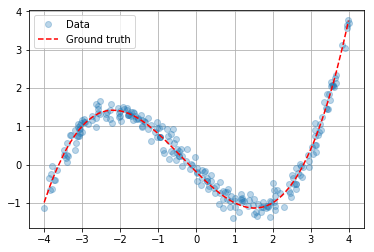

In [5]:
plt.figure(figsize=(6,4))
plt.plot(x_, y_, 'o', label='Data', alpha=0.3)
plt.plot(x_, y_truth, 'r--', label='Ground truth')
plt.grid()
_=plt.legend(loc=2)

### Define variational "Proxy" distribution

In [6]:
from inferpy import Parameter as Param
from tensorflow.math import softplus

@inf.probmodel
def qmodel(degree):
    D = degree + 1
    q_w_loc = Param(zeros([D,1]), name='q_w_loc')
    q_w_scale = softplus(Param(ones([D,1]),name = 'q_w_scale'))
    
    q_w = Normal(q_w_loc, q_w_scale, name = 'w') # same as in the MODEL
    
    q_beta_concentration = softplus(Param(zeros([D,1]), name='q_beta_concentration'))
    q_beta_rate = softplus(Param(zeros([D,1]),name = 'q_beta_rate'))
    
    q_beta = Gamma(q_beta_concentration, q_beta_rate, name = 'beta') # same as in the MODEL
    
    q_s2_concentration = softplus(Param(1., name='q_s2_concentration'))
    q_s2_rate = softplus(Param(1.,name = 'q_s2_rate'))
    
    q_s2 = Gamma(q_s2_concentration, q_s2_rate, name = 's2') # same as in the MODEL

### Initialize the Black-box inference method

In [7]:
qm = qmodel(degree)
opt = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-1)
VI = inf.inference.VI(qm, epochs=25001, optimizer=opt)

### Fit the model with the train data

In [8]:
model.fit({'x': x_, 'y':y_}, VI)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

 0 epochs	 233364.09375....................
 200 epochs	 1750.1656494140625....................
 400 epochs	 1890.8707275390625....................
 600 epochs	 2049.644287109375....................
 800 epochs	 1932.357177734375....................
 1000 epochs	 1883.173828125....................
 1200 epochs	 1999.2425537109375....................
 1400 epochs	 2042.6295166015625....................
 1600 epochs	 1829.7900390625....................
 1800 epochs	 1683.365234375....................
 2000 epochs	 1907.2364501953125....................
 2200 epochs	 1539.3424072265625....................
 2400 epochs	 1739.3045654296875....................
 2600 epochs	 1639.751953125....................
 2800 epochs	 1511.2181396484375....................
 3000 epochs	 1501.76806640625....................
 3200 epochs	 1441.795166015625....................
 3400 epochs	 1544.6802978515625.....

### Get posterior destribution

In [9]:
post =  model.posterior(['w','beta','s2']).parameters()
post

{'w': {'loc': array([[-0.14005354],
         [-0.98757035],
         [ 0.09087912],
         [ 0.10238598]], dtype=float32), 'scale': array([[0.03278725],
         [0.01829628],
         [0.00740995],
         [0.00094179]], dtype=float32), 'validate_args': False, 'allow_nan_stats': True, 'name': 'w'},
 'beta': {'concentration': array([[3.1170774],
         [5.6209526],
         [2.6553571],
         [6.1648355]], dtype=float32), 'rate': array([[5.9593854],
         [4.708812 ],
         [6.825725 ],
         [5.36769  ]], dtype=float32), 'validate_args': False, 'allow_nan_stats': True, 'name': 'beta'},
 's2': {'concentration': 19.20394,
  'rate': 34.673992,
  'validate_args': False,
  'allow_nan_stats': True,
  'name': 's2'}}

### Get posterior expected values

In [10]:
wp = post['w']['loc']
y_p = X_ @ wp
wp.shape, y_p.shape

((4, 1), (250, 1, 1))

In [11]:
sbeta = post['beta']
s_beta_hat = sbeta['concentration']/sbeta['rate']
s_beta_hat

array([[0.52305347],
       [1.1937093 ],
       [0.389022  ],
       [1.1485081 ]], dtype=float32)

In [12]:
s2p = post['s2']
s2_hat = s2p['concentration']/s2p['rate']
s2_hat

0.5538428

### Plot posterior mean

### Get posterior predictive and plot it

In [16]:
pp = model.posterior_predictive(['y'],data={'x':x_}).sample(500)

ypp = pp.mean(0).squeeze()

ypp_std = pp.std(0).squeeze()

xpp.shape, ypp.shape

((250,), (250,))

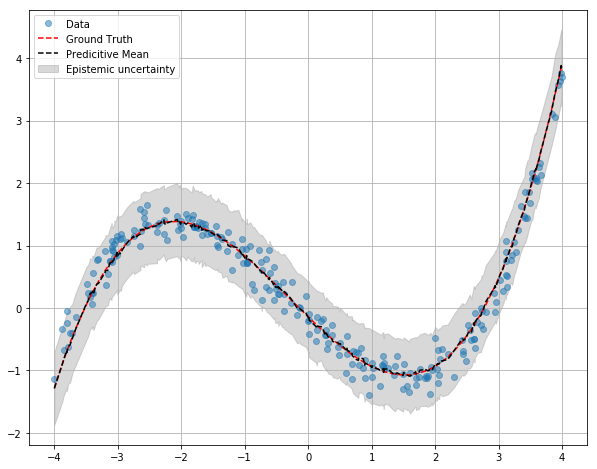

In [18]:
plt.figure(figsize=(10,8))
plt.plot(x_,y_,'o',alpha=0.5, label='Data')
plt.plot(x_,y_p.squeeze(),'r--', label='Ground Truth')
plt.plot(x_,ypp,'k--', label='Predicitive Mean')
plt.fill_between(xpp,ypp - ypp_std, ypp + ypp_std, color='grey', alpha=.3, label='Epistemic uncertainty')
plt.legend(loc=2)
_=plt.grid()